In [1]:
from keras.datasets import mnist
import numpy as np
from google.colab import drive
drive.mount('/content/drive') 

Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
from time import time
import numpy as np
import keras.backend as K
from keras.engine.topology import Layer, InputSpec
from keras.layers import Dense, Input
from keras.models import Model
from keras.optimizers import SGD
from keras import callbacks
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
import tensorflow as tf

In [3]:
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

nmi = normalized_mutual_info_score
ari = adjusted_rand_score

def acc(y_true, y_pred):
    """
    Calculate clustering accuracy. Require scikit-learn installed
    # Arguments
        y: true labels, numpy.array with shape `(n_samples,)`
        y_pred: predicted labels, numpy.array with shape `(n_samples,)`
    # Return
        accuracy, in [0,1]
    """
    y_true = y_true.astype(np.int64)
    assert y_pred.size == y_true.size
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    from scipy.optimize import linear_sum_assignment
    ind = linear_sum_assignment(w.max() - w)
    ind = np.asarray(ind)
    ind = np.transpose(ind)
    return sum([w[i, j] for i, j in ind]) * 1.0 / y_pred.size

In [4]:
def autoencoder(dims, act='relu', init='glorot_uniform'):
    """
    Fully connected auto-encoder model, symmetric.
    Arguments:
        dims: list of number of units in each layer of encoder. dims[0] is input dim, dims[-1] is units in hidden layer.
            The decoder is symmetric with encoder. So number of layers of the auto-encoder is 2*len(dims)-1
        act: activation, not applied to Input, Hidden and Output layers
    return:
        (ae_model, encoder_model), Model of autoencoder and model of encoder
    """
    n_stacks = len(dims) - 1
    # input
    input_img = Input(shape=(dims[0],), name='input')
    x = input_img
    # internal layers in encoder
    for i in range(n_stacks-1):
        x = Dense(dims[i + 1], activation=act, kernel_initializer=init, name='encoder_%d' % i)(x)

    # hidden layer
    encoded = Dense(dims[-1], kernel_initializer=init, name='encoder_%d' % (n_stacks - 1))(x)  # hidden layer, features are extracted from here

    x = encoded
    # internal layers in decoder
    for i in range(n_stacks-1, 0, -1):
        x = Dense(dims[i], activation=act, kernel_initializer=init, name='decoder_%d' % i)(x)

    # output
    x = Dense(dims[0], kernel_initializer=init, name='decoder_0')(x)
    decoded = x
    return Model(inputs=input_img, outputs=decoded, name='AE'), Model(inputs=input_img, outputs=encoded, name='encoder')

In [5]:
#Upload data
x = np.genfromtxt('/content/drive/My Drive/Data ML/.txt/ec014.42_794_796_798_spikes.txt', usecols=list(range(0,256)), skip_header=1)
parameters = np.genfromtxt('/content/drive/My Drive/Data ML/.txt/ec014.42_794_796_798_spikes.txt', dtype=None, encoding='UTF-8', usecols=list(range(256,267)), skip_header=1)
xnoise = np.genfromtxt('/content/drive/My Drive/Data ML/.txt/ec014.42_794_796_798_noise.txt', usecols=list(range(0,256)), skip_header=1)

#Normalization with max trace value
max_norm = x.max()

classification = np.empty(shape=(x.shape[0],1))
for i in range(0, x.shape[0]):
  if parameters[i][8] != 0 and parameters[i][9] == 0: #excitatory
    classification[i] = 0
  elif parameters[i][8] == 0 and parameters[i][9] != 0: #inhibitory
    classification[i] = 1
  else:
    classification[i] = 2 #neither
  i=i+1
x = np.append(x, classification, axis=1)
x = x[x[:,256] != 2] #No neither

#Create label for noise
classification = np.empty(shape=(xnoise.shape[0],1))
classification[:,0] = 2
xnoise = np.append(xnoise, classification, axis=1)


excits = x[x[:,256] == 0]
inhibs = x[x[:,256] == 1]
print("#Excting traces:", excits.shape[0])
rnd = np.random.choice(inhibs.shape[0], excits.shape[0], replace=False) #As more inhibs, choose randomly from inhibibitory to get same number of all types
inhibs = inhibs[rnd,:]
print("#Random Inhibiting traces:", inhibs.shape[0])
x = np.concatenate([excits, inhibs], axis=0) #back together

rnd_noise = np.random.choice(xnoise.shape[0], excits.shape[0], replace=False) #As more noise, choose randomly from all noise to get same number of all types
xnoise = xnoise[rnd_noise,:]
print("#Random Noise traces:", xnoise.shape[0])
x = np.concatenate([x, xnoise], axis=0) #back together

#random shuffle
x = np.take(x,np.random.permutation(x.shape[0]),axis=0,out=x) 
print("#Total traces:", x.shape[0])

y = x[:,256]
x = x[:,:-1]

#Execute Normalization
print("Normalized via max value:", max_norm)
x = np.divide(x, max_norm) 

n_clusters = len(np.unique(y))
print(np.unique(y))
print(n_clusters)

#Excting traces: 13155
#Random Inhibiting traces: 13155
#Random Noise traces: 13155
#Total traces: 39465
Normalized via max value: 1354.0
[0. 1. 2.]
3



Base line K-Means clustering accuracy

In [7]:
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x)
print(acc(y, y_pred_kmeans))

0.7745850753832509


Hyper-parameter

In [8]:
dims = [x.shape[-1], 500, 500, 2000, 7]
init = VarianceScaling(scale=1. / 3., mode='fan_in',
                           distribution='uniform')
pretrain_optimizer = 'RMSprop'
pretrain_epochs = 500
batch_size = 64
save_dir = '/content/drive/My Drive/Data ML/Model data .h5'
name_save_process = '/test.h5'
name_save_final = '/test_final.h5'


In [9]:
autoencoder, encoder = autoencoder(dims, init=init)


Pretrain auto-encoder

In [10]:
autoencoder.compile(optimizer=pretrain_optimizer, loss='mse')
autoencoder.fit(x, x, batch_size=batch_size, epochs=pretrain_epochs) #, callbacks=cb)
autoencoder.save_weights(save_dir + name_save_process)

Epoch 1/500
39465/39465 [==============================] - 29s 725us/step - loss: 0.0020
Epoch 2/500
39465/39465 [==============================] - 28s 713us/step - loss: 0.0016
Epoch 3/500
39465/39465 [==============================] - 28s 713us/step - loss: 0.0014
Epoch 4/500
39465/39465 [==============================] - 28s 716us/step - loss: 0.0013
Epoch 5/500
39465/39465 [==============================] - 28s 715us/step - loss: 0.0012
Epoch 6/500
39465/39465 [==============================] - 28s 709us/step - loss: 0.0012
Epoch 7/500
39465/39465 [==============================] - 28s 710us/step - loss: 0.0012
Epoch 8/500
39465/39465 [==============================] - 32s 814us/step - loss: 0.0011
Epoch 9/500
39465/39465 [==============================] - 28s 713us/step - loss: 0.0011
Epoch 10/500
39465/39465 [==============================] - 29s 725us/step - loss: 0.0011
Epoch 11/500
39465/39465 [==============================] - 28s 713us/step - loss: 0.0011
Epoch 12/500
39465/


Load the pre-trained auto encoder weights


In [11]:
autoencoder.load_weights(save_dir + name_save_process)


Build clustering model

In [12]:
class ClusteringLayer(Layer):
    """
    Clustering layer converts input sample (feature) to soft label, i.e. a vector that represents the probability of the
    sample belonging to each cluster. The probability is calculated with student's t-distribution.

    # Example
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters: number of clusters.
        weights: list of Numpy array with shape `(n_clusters, n_features)` witch represents the initial cluster centers.
        alpha: degrees of freedom parameter in Student's t-distribution. Default to 1.0.
    # Input shape
        2D tensor with shape: `(n_samples, n_features)`.
    # Output shape
        2D tensor with shape: `(n_samples, n_clusters)`.
    """

    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
        """ student t-distribution, as same as used in t-SNE algorithm.
         Measure the similarity between embedded point z_i and centroid µ_j.
                 q_ij = 1/(1+dist(x_i, µ_j)^2), then normalize it.
                 q_ij can be interpreted as the probability of assigning sample i to cluster j.
                 (i.e., a soft assignment)
        Arguments:
            inputs: the variable containing data, shape=(n_samples, n_features)
        Return:
            q: student's t-distribution, or soft labels for each sample. shape=(n_samples, n_clusters)
        """
        q = 1.0 / (1.0 + (K.sum(K.square(K.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
        q **= (self.alpha + 1.0) / 2.0
        q = K.transpose(K.transpose(q) / K.sum(q, axis=1)) # Make sure each sample's 10 values add up to 1.
        return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [13]:
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

In [14]:
model.compile(optimizer=SGD(0.01, 0.9), loss='kld')


Step 1: initialize cluster centers using k-means

In [15]:
kmeans = KMeans(n_clusters=n_clusters, n_init=50, n_jobs=50)
y_pred = kmeans.fit_predict(encoder.predict(x))
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])
print(acc(y, y_pred))

0.7536297985556822


Step 2: deep clustering

In [16]:
# computing an auxiliary target distribution
def target_distribution(q):
    weight = q ** 2 / q.sum(0)
    return (weight.T / weight.sum(1)).T

loss = 0
index = 0
maxiter = 8000
update_interval = 140
index_array = np.arange(x.shape[0])
tol = 0.0001 # tolerance threshold to stop training

Start Training

In [17]:
for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x, verbose=0)
        p = target_distribution(q)  # update the auxiliary target distribution p

        # evaluate the clustering performance
        y_pred = q.argmax(1)
        if y is not None:
            acc_var = np.round(acc(y, y_pred), 5)
            nmi_var = np.round(nmi(y, y_pred), 5)
            ari_var = np.round(ari(y, y_pred), 5)
            loss = np.round(loss, 5)
            print('Iter %d: acc = %.5f, nmi = %.5f, ari = %.5f' % (ite, acc_var, nmi_var, ari_var), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x.shape[0])]
    loss = model.train_on_batch(x=x[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x.shape[0] else 0

model.save_weights(save_dir + name_save_final)

Iter 0: acc = 0.75363, nmi = 0.44495, ari = 0.43519  ; loss= 0
Iter 140: acc = 0.77709, nmi = 0.48835, ari = 0.48779  ; loss= 0.00071
Iter 280: acc = 0.80436, nmi = 0.54191, ari = 0.54553  ; loss= 0.00106
Iter 420: acc = 0.82990, nmi = 0.58931, ari = 0.59483  ; loss= 0.0023
Iter 560: acc = 0.85098, nmi = 0.62290, ari = 0.63468  ; loss= 0.00658
Iter 700: acc = 0.86679, nmi = 0.64803, ari = 0.66609  ; loss= 0.02214
Iter 840: acc = 0.88083, nmi = 0.67258, ari = 0.69552  ; loss= 0.04913
Iter 980: acc = 0.89320, nmi = 0.69498, ari = 0.72224  ; loss= 0.06307
Iter 1120: acc = 0.90214, nmi = 0.71262, ari = 0.74232  ; loss= 0.07264
Iter 1260: acc = 0.90898, nmi = 0.72603, ari = 0.75794  ; loss= 0.07374
Iter 1400: acc = 0.91570, nmi = 0.73992, ari = 0.77369  ; loss= 0.06875
Iter 1540: acc = 0.92300, nmi = 0.75497, ari = 0.79094  ; loss= 0.07097
Iter 1680: acc = 0.92819, nmi = 0.76624, ari = 0.80350  ; loss= 0.0637
Iter 1820: acc = 0.93257, nmi = 0.77609, ari = 0.81423  ; loss= 0.06286
Iter 1960:

Network Visualization

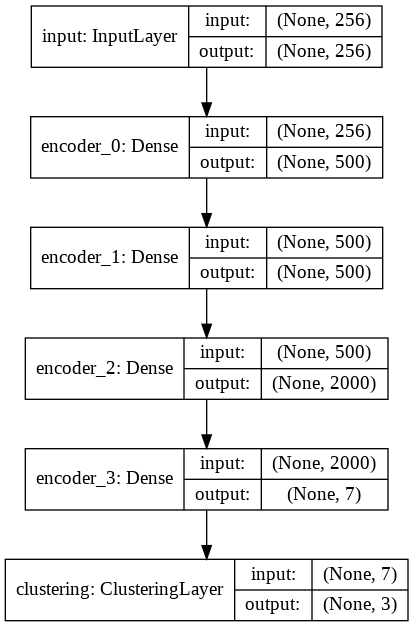

In [18]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
from IPython.display import Image
Image(filename='model.png')